In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import empyrical as ep
import alphalens as al
import pyfolio as pf

from quantopian.pipeline.data import EquityPricing
from quantopian.research.experimental import get_factor_returns, get_factor_loadings
from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline

In [2]:
bt = get_backtest('5ea3af00db710e45ab369002')

100% Time:  0:00:54|##########################################################|


In [3]:
# Compute percentage holdings
results = bt.pyfolio_positions.drop('cash', axis=1)
results.columns = results.columns.str.split('-').to_series().apply(lambda x: int(x[1]))
results = results.div(results.abs().sum(axis=1), axis=0)
results = results.stack().dropna()

In [4]:
# load the reference returns we will compare your factor returns to
comp_returns = local_csv('corporate_pension_challenge_jan_2020.csv', 
                         date_column='date')

In [5]:
start = results.index.levels[0][0]
end = min(pd.Timestamp.today(tz='UTC'), results.index.levels[0][-1] + pd.Timedelta(days=30))

In [6]:
assets = results.index.levels[1]
pricing = get_pricing(assets, start, end, fields="close_price")
stock_rets = pricing.pct_change()

# Load risk factor loadings and returns
risk_loadings = get_factor_loadings(assets, start, end)
risk_returns = get_factor_returns(start, end)
# Fix a bug in the risk returns
risk_returns.loc[risk_returns.value.idxmax(), 'value'] = 0

/venvs/py35/lib/python3.5/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/venvs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import empyrical as ep
import alphalens as al
import pyfolio as pf
   
def calc_perf_attrib(portfolio_returns, portfolio_pos, factor_returns, factor_loadings):
    import empyrical as ep
    start = portfolio_returns.index[0]
    end = portfolio_returns.index[-1]
    factor_loadings.index = factor_loadings.index.set_names(['dt', 'ticker'])
    portfolio_pos.index = portfolio_pos.index.set_names(['dt'])
    
    portfolio_pos = portfolio_pos.drop('cash', axis=1)
    portfolio_pos.columns.name = 'ticker'
    portfolio_pos.columns = portfolio_pos.columns.astype('int')
    
    return ep.perf_attrib(
        portfolio_returns, 
        portfolio_pos.stack().dropna(),
        factor_returns.loc[start:end], 
        factor_loadings.loc[start:end])

def plot_exposures(risk_exposures, ax=None):
    rep = risk_exposures.stack().reset_index()
    rep.columns = ['dt', 'factor', 'exposure']
    sns.boxplot(x='exposure', y='factor', data=rep, orient='h', ax=ax, order=risk_exposures.columns[::-1])

def compute_turnover(df):
    return df.dropna().unstack().dropna(how='all').fillna(0).diff().abs().sum(1)

def get_max_median_position_concentration(expos):
    longs = expos.loc[expos > 0]
    shorts = expos.loc[expos < 0]

    return expos.groupby(level=0).quantile([.05, .25, .5, .75, .95]).unstack()

def compute_uniq(factor_returns, comp_returns):
    idx = factor_returns.dropna().index.intersection(comp_returns.dropna().index)
    cr = comp_returns.loc[idx].values
    fr = factor_returns.loc[idx].values
    c = cr @ (cr.T @ fr)
    residuum = c - fr
    return residuum.var() / factor_returns.loc[idx].var()

def compute_factor_stats(factor, pricing, factor_returns, factor_loadings, comp_returns, 
                         periods=range(1, 15)):
    factor_data_total = al.utils.get_clean_factor_and_forward_returns(
        factor, 
        pricing,
        quantiles=None,
        bins=(-np.inf, 0, np.inf),
        periods=periods,
        cumulative_returns=False,
    )

    portfolio_returns_total = al.performance.factor_returns(factor_data_total)
    portfolio_returns_total.columns = portfolio_returns_total.columns.map(lambda x: int(x[:-1]))
    for i in portfolio_returns_total.columns:
        portfolio_returns_total[i] = portfolio_returns_total[i].shift(i)

    portfolio_returns_specific = pd.DataFrame(columns=portfolio_returns_total.columns, index=portfolio_returns_total.index)
    
    # closure
    def calc_perf_attrib_c(i, portfolio_returns_total=portfolio_returns_total, 
                           factor_data_total=factor_data_total, factor_returns=factor_returns, 
                           factor_loadings=factor_loadings):
        return calc_perf_attrib(portfolio_returns_total[i], 
                                factor_data_total['factor'].unstack().assign(cash=0).shift(i), 
                                factor_returns, factor_loadings)
    
    perf_attrib = map(calc_perf_attrib_c, portfolio_returns_total.columns)
        
    for i, pa in enumerate(perf_attrib):
        if i == 0:
            risk_exposures_portfolio = pa[0]
            perf_attribution = pa[1]
        portfolio_returns_specific[i + 1] = pa[1]['specific_returns']
    
    delay_sharpes_total = portfolio_returns_total.apply(ep.sharpe_ratio)
    delay_sharpes_specific = portfolio_returns_specific.apply(ep.sharpe_ratio)
    
    turnover = compute_turnover(factor)
    n_holdings = factor.groupby(level=0).count()
    perc_holdings = get_max_median_position_concentration(factor)
    
    uniq_score = compute_uniq(portfolio_returns_total[1].iloc[1:], comp_returns)
    
    return {'factor_data_total': factor_data_total, 
            'portfolio_returns_total': portfolio_returns_total,
            'portfolio_returns_specific': portfolio_returns_specific,
            'risk_exposures_portfolio': risk_exposures_portfolio,
            'perf_attribution': perf_attribution,
            'delay_sharpes_total': delay_sharpes_total,
            'delay_sharpes_specific': delay_sharpes_specific,
            'turnover': turnover,
            'n_holdings': n_holdings,
            'perc_holdings': perc_holdings,
            'uniq_score': uniq_score,
    }

def plot_overview_tear_sheet(factor, pricing, factor_returns, factor_loadings, comp_returns, periods=range(1, 15)):
    fig = plt.figure(figsize=(16, 16))
    gs = plt.GridSpec(5, 4)
    ax1 = plt.subplot(gs[0:2, 0:2])
    
    factor_stats = compute_factor_stats(factor, pricing, factor_returns, factor_loadings, 
                                        comp_returns, periods=periods)
    
    fig.suptitle('Uniqueness score = {:.2f}%'.format(100 * factor_stats['uniq_score']))
    
    pd.DataFrame({'specific': factor_stats['delay_sharpes_specific'], 
                  'total': factor_stats['delay_sharpes_total']}).plot.bar(ax=ax1)
    ax1.set(xlabel='delay', ylabel='IR')

    ax2a = plt.subplot(gs[0, 2:4])
    delay_cum_rets_total = factor_stats['portfolio_returns_total'][list(range(1, 5))].apply(ep.cum_returns)
    delay_cum_rets_total.plot(ax=ax2a)
    ax2a.set(title='Total returns', ylabel='Cumulative returns')
    
    ax2b = plt.subplot(gs[1, 2:4])
    delay_cum_rets_specific = factor_stats['portfolio_returns_specific'][list(range(1, 5))].apply(ep.cum_returns)
    delay_cum_rets_specific.plot(ax=ax2b)
    ax2b.set(title='Specific returns', ylabel='Cumulative returns')
    
    ax3 = plt.subplot(gs[2:4, 0:2])
    plot_exposures(factor_stats['risk_exposures_portfolio'].reindex(columns=factor_stats['perf_attribution'].columns), 
                   ax=ax3)

    ax4 = plt.subplot(gs[2:4, 2])
    ep.cum_returns_final(factor_stats['perf_attribution']).plot.barh(ax=ax4)
    ax4.set(xlabel='Cumulative returns')

    ax5 = plt.subplot(gs[2:4, 3], sharey=ax4)
    factor_stats['perf_attribution'].apply(ep.annual_volatility).plot.barh(ax=ax5)
    ax5.set(xlabel='Ann. volatility')

    ax6 = plt.subplot(gs[-1, 0:2])
    factor_stats['n_holdings'].plot(color='b', ax=ax6)
    ax6.set_ylabel('# holdings', color='b')
    ax6.tick_params(axis='y', labelcolor='b')
    
    ax62 = ax6.twinx()
    factor_stats['turnover'].plot(color='r', ax=ax62)
    ax62.set_ylabel('turnover', color='r')
    ax62.tick_params(axis='y', labelcolor='r')
    
    ax7 = plt.subplot(gs[-1, 2:4])
    factor_stats['perc_holdings'].plot(ax=ax7)
    ax7.set(ylabel='% allocation', title='Quantile of daily holdings')
    
    gs.tight_layout(fig)
    
    return fig, factor_stats

Dropped 0.4% entries from factor data: 0.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


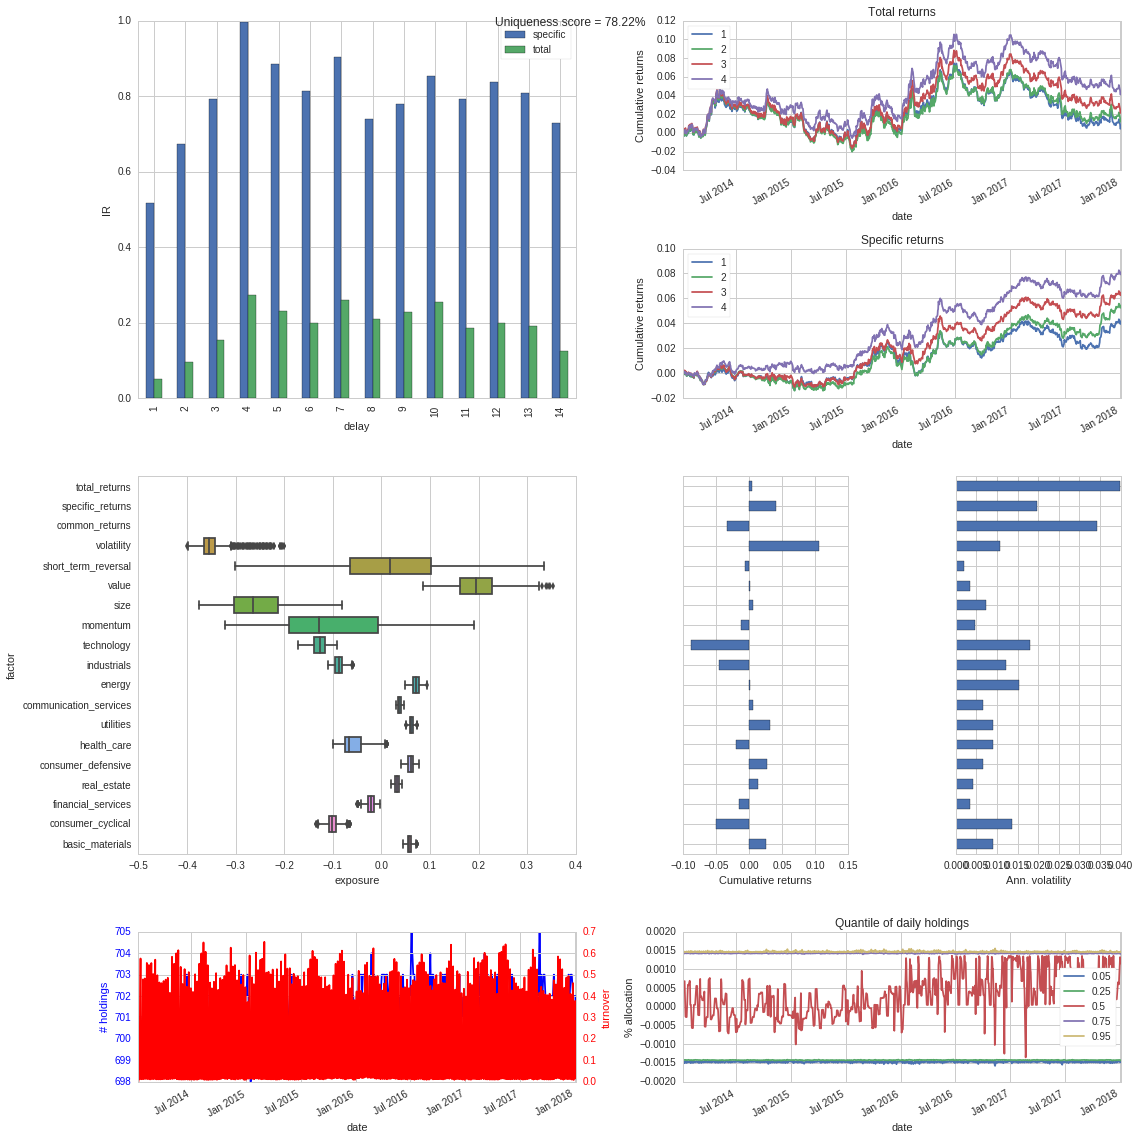

In [8]:
_, factor_stats = plot_overview_tear_sheet(results, 
                                           pricing, 
                                           risk_returns, 
                                           risk_loadings,
                                           comp_returns);